In [42]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers,models
import torch

In [43]:
dataset_path = "Dataset"

In [44]:
# Mengecek apakah path ada
if os.path.exists(dataset_path):
    print("Dataset ditemukan di path tersebut.")
else:
    print("Dataset tidak ditemukan di path tersebut.")

Dataset ditemukan di path tersebut.


In [45]:
# Kompilasi dataset
all_files = []
all_labels = []
classes = os.listdir(dataset_path)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)

    for img in images:
        all_files.append(os.path.join(class_path, img))
        all_labels.append(class_name)


In [46]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

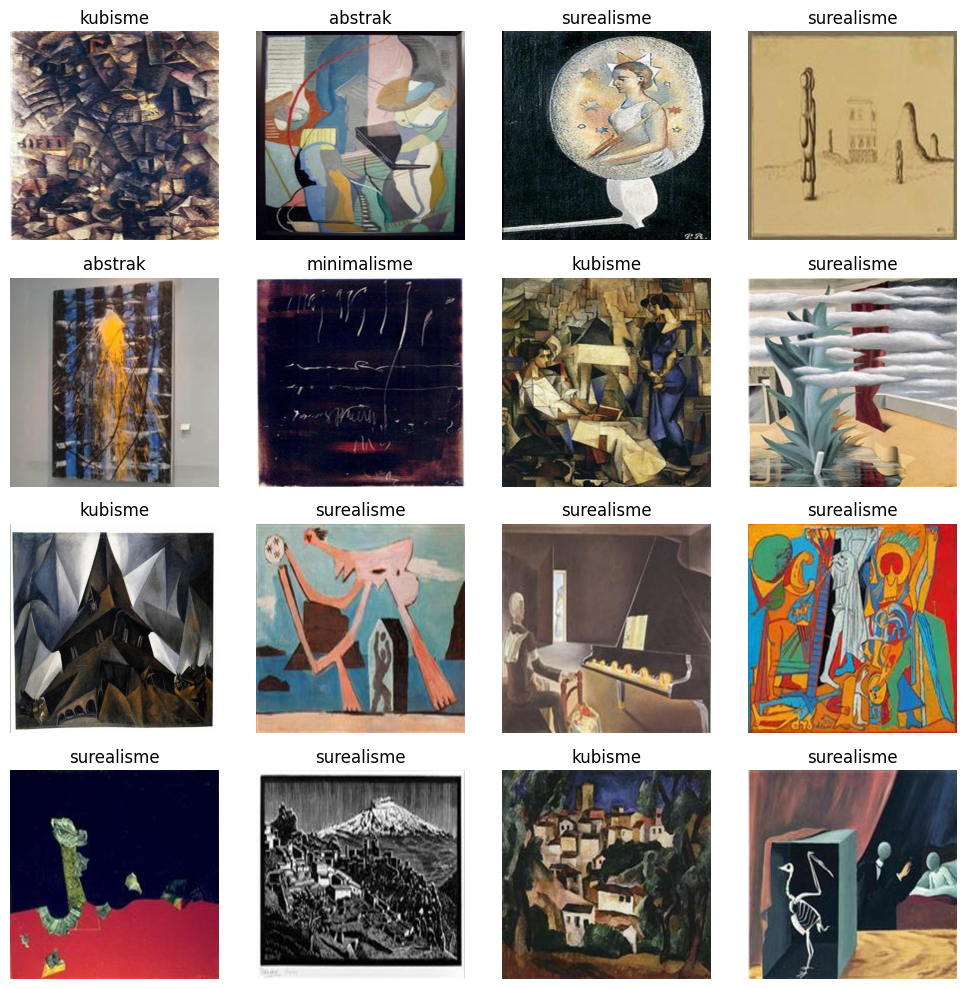

In [47]:
# Tampilkan sampel dataset
plt.figure(figsize=(10,10))
for i in range (16):
  plt.subplot(4,4,i+1)
  img = mpimg.imread(X_train[i])
  plt.imshow(img)
  plt.title(y_train[i])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
plt.tight_layout()  # Atur tata letak agar rapi
plt.show()

In [48]:
from PIL import Image
def load_and_preprocess_images(file_paths):
  images = []
  for file_path in file_paths:
    try:
        img = Image.open(file_path)
        img.verify()
    except Exception as e:
        print(f"Corrupt image: {file_path}, error: {e}")

    # Load image 
    img = cv2.imread(file_path)
    # Resize
    img = cv2.resize(img, (224, 224))  
    # Normalize 
    img = img / 255.0
    images.append(img)
  # Konversi ke array NumPy 
  return np.array(images)

X_train = load_and_preprocess_images(X_train)
X_test = load_and_preprocess_images(X_test)

In [49]:
# Encode Label
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [50]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

In [11]:
from tensorflow.keras import regularizers
model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax',kernel_regularizer=regularizers.l2(0.01))  # Output layer untuk klasifikasi
])

In [13]:
import tensorflow as tf
X_train = tf.image.resize(X_train, (224, 224))
X_test = tf.image.resize(X_test, (224, 224))

In [36]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
50/50 [==============================] - 302s 5s/step - loss: 4.5689 - accuracy: 0.1969 - val_loss: 3.5989 - val_accuracy: 0.4050
Epoch 2/20
50/50 [==============================] - 222s 4s/step - loss: 3.5580 - accuracy: 0.2819 - val_loss: 3.0823 - val_accuracy: 0.3950
Epoch 3/20
50/50 [==============================] - 229s 5s/step - loss: 3.0803 - accuracy: 0.3006 - val_loss: 2.7230 - val_accuracy: 0.3925
Epoch 4/20
50/50 [==============================] - 250s 5s/step - loss: 2.7319 - accuracy: 0.3300 - val_loss: 2.4468 - val_accuracy: 0.4075
Epoch 5/20
50/50 [==============================] - 267s 5s/step - loss: 2.4955 - accuracy: 0.3500 - val_loss: 2.2423 - val_accuracy: 0.4025
Epoch 6/20
50/50 [==============================] - 240s 5s/step - loss: 2.2771 - accuracy: 0.3487 - val_loss: 2.0716 - val_accuracy: 0.4275
Epoch 7/20
50/50 [==============================] - 223s 4s/step - loss: 2.1223 - accuracy: 0.3694 - val_loss: 1.9436 - val_accuracy: 0.4300
Epoch 8/20
50

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 23851274 (90.99 MB)
Trainable params: 263562 (1.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

13/13 [==============================] - 49s 3s/step
Test Loss: 1.4854
Test Accuracy: 0.4475

Classification Report:
              precision    recall  f1-score   support

     abstrak       0.35      0.38      0.37       100
     kubisme       0.49      0.46      0.48       100
 minimalisme       0.56      0.76      0.65       100
  surealisme       0.30      0.19      0.23       100

    accuracy                           0.45       400
   macro avg       0.43      0.45      0.43       400
weighted avg       0.43      0.45      0.43       400


Confusion Matrix:


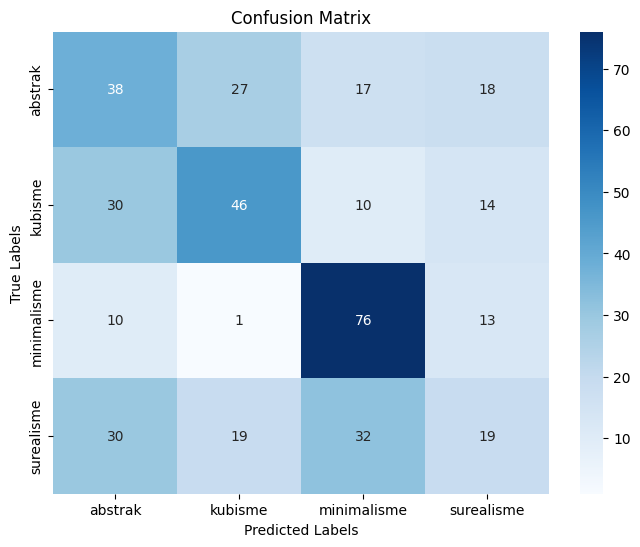

In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels

# Calculate and print evaluation metrics
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes,zero_division=1, target_names=label_encoder.classes_))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

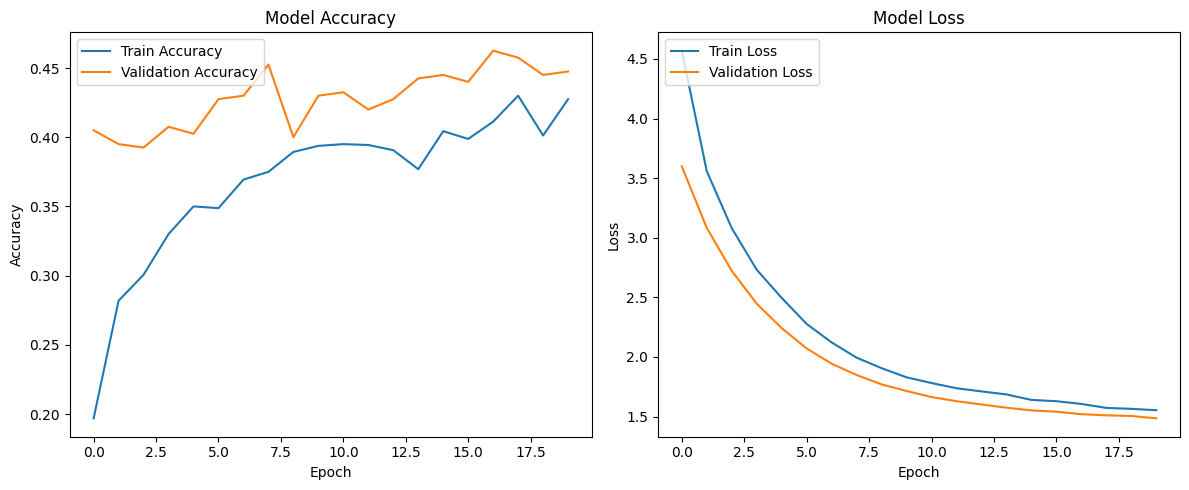

In [39]:
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function to plot accuracy and loss
plot_training_history(history)

In [40]:
from sklearn.metrics import classification_report

# Assuming `model` is your trained model, and X_test, y_test are your test data
predictions = model.predict(X_test)


predicted_classes = predictions.argmax(axis=1)

# Generate the classification report
class_report = classification_report(y_test, y_pred_classes,zero_division=1, target_names=label_encoder.classes_)
print("\nClassification Report:\n", class_report)


13/13 [==============================] - 43s 3s/step

Classification Report:
               precision    recall  f1-score   support

     abstrak       0.35      0.38      0.37       100
     kubisme       0.49      0.46      0.48       100
 minimalisme       0.56      0.76      0.65       100
  surealisme       0.30      0.19      0.23       100

    accuracy                           0.45       400
   macro avg       0.43      0.45      0.43       400
weighted avg       0.43      0.45      0.43       400



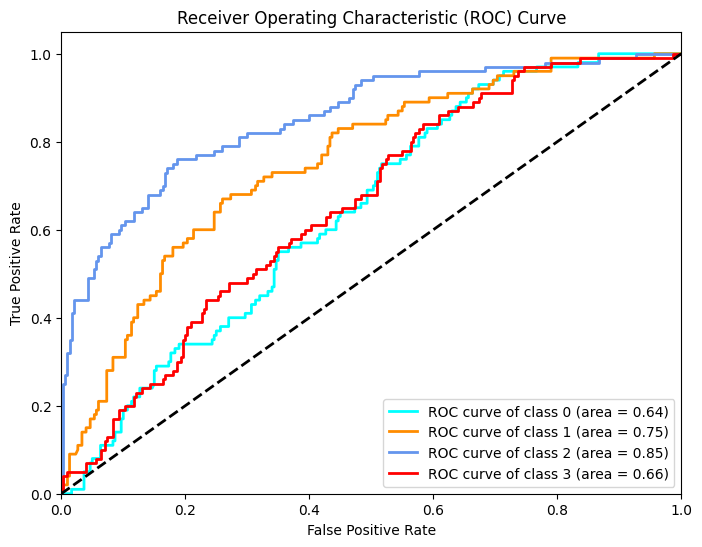

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make sure y_test contains class labels (not one-hot encoded), and predictions contains probabilities
fpr = {}
tpr = {}
roc_auc = {}

# Number of classes (adjust this if needed)
num_classes = 4  # Adjust based on your dataset

for i in range(num_classes):
    # For class i, create a binary label for y_test and get the probabilities for class i from predictions
    y_test_binary = (y_test == i).astype(int)  # Create binary labels for the class
    # Get the predicted probabilities for class i
    predictions_class = predictions[:, i]  # Assuming predictions is of shape (num_samples, num_classes)

    # Calculate FPR, TPR, and AUC for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, predictions_class)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
# Regularisasi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=32)

In [62]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze 50 layer terakhir
resnet_base.trainable = False
for layer in resnet_base.layers[-50:]:
    layer.trainable = True
    

In [63]:
from tensorflow.keras import regularizers
model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax',kernel_regularizer=regularizers.l2(0.01))  # Output layer untuk klasifikasi
])

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
batch_size=32
history_after=model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=15,
    validation_data=(X_test, y_test)  
)

Epoch 1/15
50/50 [==============================] - 124s 2s/step - loss: 4.3119 - accuracy: 0.2763 - val_loss: 4.4332 - val_accuracy: 0.2600
Epoch 2/15
50/50 [==============================] - 129s 3s/step - loss: 3.8904 - accuracy: 0.3469 - val_loss: 3.9902 - val_accuracy: 0.2550
Epoch 3/15
50/50 [==============================] - 133s 3s/step - loss: 3.6529 - accuracy: 0.3694 - val_loss: 3.7210 - val_accuracy: 0.3650
Epoch 4/15
45/50 [==========================>...] - ETA: 10s - loss: 3.4862 - accuracy: 0.4014

In [ ]:
model.summary()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels

# Calculate and print evaluation metrics
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes,zero_division=1, target_names=label_encoder.classes_))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function to plot accuracy and loss
plot_training_history(history_after)

In [ ]:
from sklearn.metrics import classification_report

# Assuming `model` is your trained model, and X_test, y_test are your test data
predictions = model.predict(X_test)


predicted_classes = predictions.argmax(axis=1)

# Generate the classification report
class_report = classification_report(y_test, y_pred_classes,zero_division=1, target_names=label_encoder.classes_)
print("\nClassification Report:\n", class_report)


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make sure y_test contains class labels (not one-hot encoded), and predictions contains probabilities
fpr = {}
tpr = {}
roc_auc = {}

# Number of classes (adjust this if needed)
num_classes = 4  # Adjust based on your dataset

for i in range(num_classes):
    # For class i, create a binary label for y_test and get the probabilities for class i from predictions
    y_test_binary = (y_test == i).astype(int)  # Create binary labels for the class
    # Get the predicted probabilities for class i
    predictions_class = predictions[:, i]  # Assuming predictions is of shape (num_samples, num_classes)

    # Calculate FPR, TPR, and AUC for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, predictions_class)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import joblib

# Misalnya model Anda adalah 'model'
joblib.dump(model, 'Resnet.pkl') 